In [3]:
import os, glob, re
from os.path import join
import argparse
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
from pathlib import Path
import nilearn
import pandas as pd
import nibabel as nib
import seaborn as sns
from nilearn import plotting
from nilearn import image
from nilearn import masking
import matplotlib.colors
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.rdm import RDMs
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
import rsatoolbox
from scipy.spatial.distance import pdist, squareform


In [6]:

# functions __________________________________________________________________
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]


def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap

def load_searchlight(singletrial_dir, sub, ses):
    """Load single trial average beta estimates within session

    Args:
        singletrial_dir (str): directory containing single trial beta estimates
        sub (str): BIDS subject id
        ses (str): BIDS session id
        run (str): BIDS run id

    Returns:
        np.array: numpy array of shape num_samples num_labels
    """
    from nilearn import datasets
    from nilearn import masking
    get_shape = glob.glob(join(
            singletrial_dir, sub, f'{sub}_{ses}_*_runtype-*_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz'))
    print(f"get_shape: {get_shape}")
    tmp_img = nib.load(get_shape[0])
    x, y, z = tmp_img.get_fdata().shape
    # arr = np.empty((0, get_shape_data.shape[0]), int)
    arr = np.empty((0, tmp_img.get_fdata().ravel().shape[0]), int)
    # Stimulus trials for the given runtype.
    masklist = []
    for runtype in ['pain', 'cognitive', 'vicarious']:
        run = '*'
        stim_H_cue_H = sorted(glob.glob(join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
        stim_M_cue_H = sorted(glob.glob(join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
        stim_L_cue_H = sorted(glob.glob(join( 
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
        stim_H_cue_L = sorted(glob.glob(join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
        stim_M_cue_L = sorted(glob.glob(join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
        stim_L_cue_L = sorted(glob.glob(join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))
        stim_flist = []
        [stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H,
                           stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]

        stim_H_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
        stim_M_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
        stim_L_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
        stim_H_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
        stim_M_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
        stim_L_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()
        runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean,
                                    stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))
        arr = np.concatenate((arr, runwise_array), axis=0)
        # mask = ~np.isnan(image.load_img(image.concat_imgs([stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
                                    # stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])).get_fdata())
        masklist.extend([stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
                                stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])
        # image.concat_imgs([mask, stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
        #                         stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])
    #print(masklist)
    print(len(masklist))
    mask_img = masking.compute_brain_mask(masklist, threshold=.1)
    print(f"mask image shape: {mask_img.get_fdata().shape}")
    print(f"number of nan values in mask:{np.sum(~np.isnan(mask_img.get_fdata()))}")
    return arr, mask_img, x,y,z


def load_expect(data_dir, sub, ses ):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_expect = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist: 
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_02expect = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns=['trial_order', 'run_order'],
                            values=['event02_expect_angle']) #, aggfunc='first')
        seswise_02expect.columns  = [col[0]+'_'+str(col[1]) for col in seswise_02expect.columns.values]
        seswise_02expect = seswise_02expect.reset_index()
        seswise_02expect["condition"] = task + '_' + seswise_02expect['param_cue_type'].astype(str) + '_' + seswise_02expect["param_stimulus_type"]

        # reorder values
        seswise_02expect['stim_order'] = seswise_02expect['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})  
        seswise_02expect['cue_order'] = seswise_02expect['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})    
        ses_expect = seswise_02expect.sort_values(['cue_order','stim_order'])
        seswise_expect = pd.concat([seswise_expect, ses_expect])
    return(seswise_expect.reset_index(drop = True))


def get_unique_run(sub_id, ses, singletrial_dir):
    """
    Extracts unique values of 'ses' and 'run' from a singletrial nifti file

    Args:
        sub_id (str): BIDS subject
        singletrial_dir (str): path to directory containing the singletrial nifti files

    Returns:
        [type]: set of unique values of ses and run
    """

    flist = glob.glob(
        join(singletrial_dir, sub_id, f"*{ses}*stimulus*trial-000_*.nii.gz")
    )
    # Initialize empty sets to store unique values of 'ses' and 'run'
    # unique_ses = set()
    unique_run = set()

    # Loop through each file path and extract 'ses-##' and 'run-##' using regular expressions
    # Extract ses run and ses.
    for path in flist:
        # Extract 'ses-##' using regular expression
        # ses_match = re.search(r"ses-(\d+)", path)
        # # Add a new session to the unique_ses list
        # if ses_match:
        #     unique_ses.add(ses_match.group(0))

        # Extract 'run-##' using regular expression
        run_match = re.search(r"run-(\d+)", path)
        # Add run_match to unique_run list of run_match. group 0
        if run_match:
            unique_run.add(run_match.group(0))
    return  unique_run


In [8]:
# parameters
nifti_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
modelRDM_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/rsa/modelrdm'

In [4]:
current_dir = os.getcwd()
main_dir = '/Volumes/spacetop_projects_cue'
print(main_dir)
# print(args.slurm_id)
slurm_id = 35 # e.g. 1, 2
singletrial_dir = join(main_dir, 'analysis/fmri/nilearn/singletrial')
sub_folders = next(os.walk(singletrial_dir))[1]
print(sub_folders)
sub_list = [i for i in sorted(sub_folders) if i.startswith('sub-')]
sub = sub_list[slurm_id]#f'sub-{sub_list[slurm_id]:04d}'
fmri_event = 'stimulus'
ses = 'ses-01'
print(f" ________ {sub} {ses} ________")
# nifti_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
local_dir = '/Users/h/Documents/projects_local/sandbox'
modelRDM_dir = join(main_dir, 'analysis/fmri/nilearn/rsa/modelrdm')
nifti_dir = join(main_dir, 'analysis/fmri/nilearn/singletrial/')
# save_dir = join(main_dir, 'analysis/fmri/nilearn/rsa/deriv03_searchlight')
save_dir = join(main_dir,'analysis/fmri/nilearn/rsa/deriv03_searchlight', sub)
Path(save_dir).mkdir( parents=True, exist_ok=True )

/Volumes/spacetop_projects_cue
['sub-0117', 'sub-0050', 'sub-0005', 'sub-0124', 'sub-0032', 'sub-0080', 'sub-0026', 'sub-0030', 'sub-0019', 'sub-0084', 'sub-0076', 'sub-0002', 'sub-0120', 'sub-0061', 'sub-0070', 'sub-0062', 'sub-0038', 'sub-0127', 'sub-0107', 'sub-0066', 'sub-0041', 'sub-0091', 'sub-0115', 'sub-0090', 'sub-0059', 'sub-0079', 'sub-0133', 'sub-0114', 'sub-0106', 'sub-0077', 'sub-0073', 'sub-0128', 'sub-0047', 'sub-0094', 'sub-0051', 'sub-0064', 'sub-0035', 'sub-0109', 'sub-0037', 'sub-0082', 'sub-0071', 'sub-0007', 'sub-0122', 'sub-0075', 'sub-0028', 'sub-0039', 'sub-0008', 'sub-0056', 'sub-0087', 'sub-0116', 'sub-0068', 'sub-0123', 'sub-0102', 'sub-0033', 'sub-0078', 'sub-0119', 'sub-0009', 'sub-0025', 'sub-0089', 'sub-0018', 'sub-0003', 'sub-0129', 'sub-0083', 'sub-0011', 'sub-0052', 'sub-0085', 'sub-0074', 'sub-0055', 'sub-0060', 'sub-0093', 'sub-0031', 'sub-0126', 'sub-0118', 'sub-0099', 'sub-0017', 'sub-0023', 'sub-0006', 'sub-0088', 'sub-0086', 'sub-0069', 'sub-009

In [7]:
arr, mask, x,y,z = load_searchlight(nifti_dir, sub, ses)

get_shape: ['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0043/sub-0043_ses-01_run-03_runtype-cognitive_event-stimulus_trial-011_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0043/sub-0043_ses-01_run-05_runtype-vicarious_event-stimulus_trial-002_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0043/sub-0043_ses-01_run-03_runtype-cognitive_event-stimulus_trial-006_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0043/sub-0043_ses-01_run-04_runtype-cognitive_event-stimulus_trial-003_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0043/sub-0043_ses-01_run-06_runtype-pain_event-stimulus_trial-004_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0043/sub-0043

In [8]:
plotting.plot_stat_map(mask)
plt.savefig(join(save_dir, f"mask_{sub}_{ses}.png"))
plt.close()
imgfname = glob.glob(join(nifti_dir, sub, f'{sub}_{ses}_*_runtype-vicarious_event-{fmri_event}_*_cuetype-low_stimintensity-low.nii.gz'))
ref_img = image.load_img(imgfname[0])
nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

singlemasked = []
for index in range(arr.shape[0]):
    singlemasked.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, arr[index].reshape(x,y,z)))
    )
fmri_masked_single = np.vstack(singlemasked)

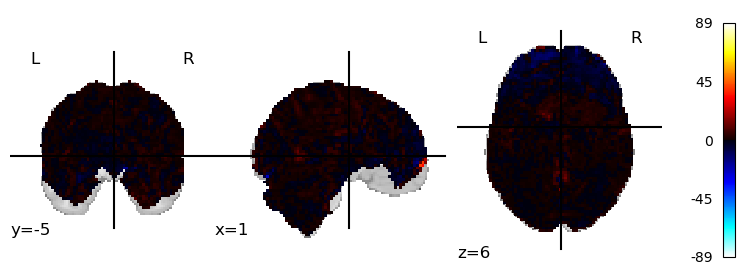

In [306]:
masked_arr = nifti_masker.inverse_transform(fmri_masked_single)
img = new_img_like(ref_img, masked_arr.get_fdata()[..., 0])
plotting.plot_stat_map(img)

In [252]:
data_2d_nan.shape



(18, 458294)

In [278]:
masked_arr.get_fdata()[:, :, :, 0:1].shape

(73, 86, 73, 1)

In [281]:
masked_arr.get_fdata()[:, :, :, 0:1].ravel()

array([0., 0., 0., ..., 0., 0., 0.])

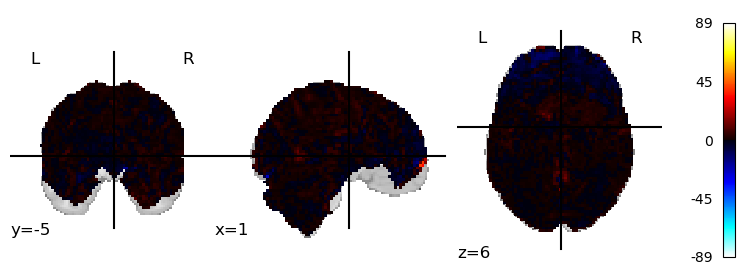

In [279]:
plot_img = new_img_like(nifti_masker.mask_img, masked_arr.get_fdata()[:, :, :, 0:1])#data_2d_nan[0].reshape((z,y,x)))
plotting.plot_stat_map(plot_img)

In [305]:
# masked_arrT = masked_arr.get_fdata().T
# reshaped_array = masked_arrT.reshape([masked_arrT.shape[0], -1])
image_value = np.arange(masked_arr.get_fdata().shape[-1]) #np.arange(reshaped_array.shape[0])#np.arange(masked_arr.shape[-1])
# reshaped_array = np.reshape(masked_arr.get_fdata(), (-1, masked_arr.shape[3]))
for i in np.arange(masked_arr.get_fdata().shape[-1]):
    data_2d[i] = masked_arr.get_fdata()[:, :, :, i:i+1].ravel()
# data_2d = reshaped_array #reshaped_array.T #masked_arr.reshape([masked_arr.shape[0], -1])
data_2d_nan = np.nan_to_num(data_2d)

IndexError: list assignment index out of range

In [284]:
data_2d_nan[0].shape

(458294,)

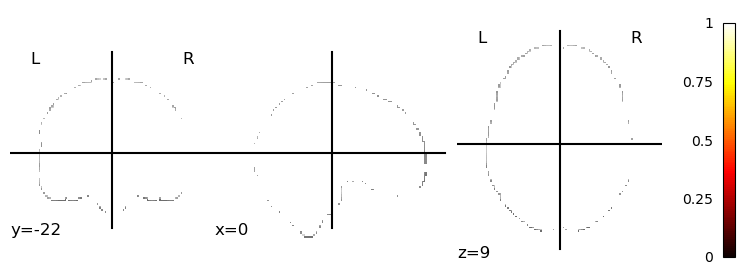

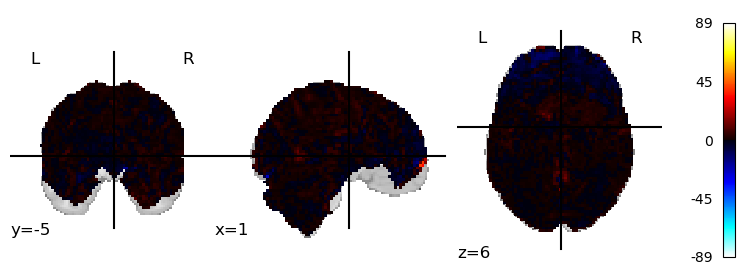

In [285]:
plotting.plot_stat_map(nifti_masker.mask_img)

plot_img = new_img_like(nifti_masker.mask_img, data_2d_nan[0].reshape((x,y,z)))#data_2d_nan[0].reshape((z,y,x)))
plotting.plot_stat_map(plot_img)

In [242]:
np.min(masked_arr.get_fdata())
np.max(masked_arr.get_fdata())
np.min(data_2d_nan)
np.max(data_2d_nan)

91.35868835449219

In [289]:
centers, neighbors = get_volume_searchlight(nifti_masker.mask_img.get_fdata(), radius=2, threshold=0.5)


[]

In [292]:
np.arange(masked_arr.get_fdata().shape[-1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [304]:
masked_arr.get_fdata()[:, :, :, i:i+1].ravel()

array([0., 0., 0., ..., 0., 0., 0.])

In [309]:
# %% Step 1: Get searchlight centers and neighbors ____________________________________________
# # %% Step 2: Get an RDM for each voxel¶
# masked_arrT = []
# masked_arrT = masked_arr.get_fdata().T
# reshaped_array = masked_arrT.reshape([masked_arrT.shape[0], -1])
# image_value = np.arange(reshaped_array.shape[0]) #np.arange(masked_arr.shape[-1])
# # reshaped_array = np.reshape(masked_arr.get_fdata(), (-1, masked_arr.shape[3]))
# data_2d = reshaped_array #reshaped_array.T #masked_arr.reshape([masked_arr.shape[0], -1])
# data_2d_nan = np.nan_to_num(data_2d)

# DEBUG:

image_value = np.arange(masked_arr.get_fdata().shape[-1]) #np.arange(reshaped_array.shape[0])#np.arange(masked_arr.shape[-1])
# reshaped_array = np.reshape(masked_arr.get_fdata(), (-1, masked_arr.shape[3]))
data_2d = np.zeros((masked_arr.get_fdata().shape[-1], (x*y*z)))
for i in np.arange(masked_arr.get_fdata().shape[-1]):
    
    data_2d[i] = masked_arr.get_fdata()[..., i].ravel()
# data_2d = reshaped_array #reshaped_array.T #masked_arr.reshape([masked_arr.shape[0], -1])
data_2d_nan = np.nan_to_num(data_2d)
SL_RDM = get_searchlight_RDMs(data_2d_nan, centers, neighbors, image_value, method='correlation') # Get RDMs

print(f"voxel indices: {SL_RDM.rdm_descriptors['voxel_index'].shape}")
print(f"number of nans?: {np.sum(np.isnan(SL_RDM.dissimilarities))}")
print(f"number of nan in mask? {np.sum(np.isnan(mask.get_fdata()))}")
print(f"centers shape: {centers.shape}")
print(f"searchlight RDM shape: {SL_RDM.dissimilarities.shape}")


Calculating RDMs...:   0%|          | 0/100 [00:00<?, ?it/s]/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/rsatoolbox/rdm/calc.py:209: RuntimeWarning: invalid value encountered in divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]
Calculating RDMs...: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]

voxel indices: (97040,)
number of nans?: 381483
number of nan in mask? 0
centers shape: (97040,)
searchlight RDM shape: (97040, 153)


In [11]:
# %% Step 3: Load animal model and evaluate
# model_grid ________________________________________________________________________________
modelRDM_dir = join(main_dir,'analysis', 'fmri', 'nilearn', 'rsa', 'modelrdm')
cue_RDM = np.load(join(modelRDM_dir, 'model-cue.npy'))
stim_RDM = np.load(join(modelRDM_dir, 'model-stim.npy'))
grid_RDM = np.load(join(modelRDM_dir, 'model-grid.npy'))
orthogonal_RDM = np.load(join(modelRDM_dir, 'model-orthogonal.npy'))
rotationgrid_RDM = np.load(join(modelRDM_dir, 'model-rotationgrid.npy'))
parallel_RDM = np.load(join(modelRDM_dir, 'model-parallel.npy'))
diagonal_RDM = np.load(join(modelRDM_dir, 'model-diagonal.npy'))


In [310]:
np.sum(np.isnan(SL_RDM.dissimilarities))

381483

In [311]:
SL_RDM.dissimilarities[np.isnan(SL_RDM.dissimilarities)] = 0


In [312]:
X = [rsatoolbox.model.ModelWeighted('cue', upper_tri(cue_RDM)),
     rsatoolbox.model.ModelWeighted('stim', upper_tri(stim_RDM)),
     rsatoolbox.model.ModelWeighted('grid', upper_tri(grid_RDM)),
     rsatoolbox.model.ModelWeighted('orthogonal', upper_tri(orthogonal_RDM)),
     rsatoolbox.model.ModelWeighted('rotationgrid', upper_tri(rotationgrid_RDM)),
     rsatoolbox.model.ModelWeighted('parallel', upper_tri(parallel_RDM)),
     rsatoolbox.model.ModelWeighted('diagonal', upper_tri(diagonal_RDM))]

In [313]:
model_names = ['cue', 'stim', 'grid', 'orthogonal', 'rotationgrid',  'parallel', 'diagonal']   
eval_results = evaluate_models_searchlight(SL_RDM, X, eval_fixed, method='spearman', n_jobs=3)

Evaluating models for each searchlight: 100%|██████████| 97040/97040 [02:38<00:00, 612.62it/s] 


In [314]:
eval_results[0].evaluations[0]

array([[ 0.00326131],
       [-0.10734335],
       [-0.01144118],
       [ 0.01836102],
       [-0.08222303],
       [ 0.04165697],
       [-0.0238852 ]])

In [315]:
df = pd.DataFrame(index=range(len(X)), columns=range(len(eval_results)))
for i, e in enumerate(eval_results):
    df.iloc[:,i] = e.evaluations[0]

In [316]:
SL_RDM

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
correlation
dissimilarities = 
[[ 1.29595756e+00  1.50377395e-01  3.32161409e-01 ...  7.49142749e-02
   7.37053109e-02  9.36950175e-02]
 [ 9.88782534e-01  8.80214759e-02  6.09860762e-02 ...  9.57154382e-02
   9.83392711e-02  2.11970787e-01]
 [ 1.10136714e+00  1.32626398e-01  1.69946308e-01 ...  1.02077339e-01
   7.51644472e-02  1.53271051e-01]
 ...
 [ 3.90937347e-01  3.15299111e-01  1.22953783e-01 ...  6.98191288e-01
   1.06406661e-01  8.43788807e-01]
 [ 1.47046460e-01  3.15818192e-04  2.09193047e-02 ... -2.22044605e-16
   2.00000000e+00  2.00000000e+00]
 [ 4.61155823e-01  7.78617572e-02  4.75067633e-02 ...  1.33925344e-01
   8.36077820e-01  5.95791235e-01]]
descriptors = 
{}
rdm_descriptors = 
{'voxel_index': array([ 59085,  59157,  59158, ..., 398243, 398531, 398532]), 'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 

In [317]:
mask.get_fdata().ravel().shape

(458294,)

In [319]:
SL_RDM.rdm_descriptors['voxel_index']

array([ 59085,  59157,  59158, ..., 398243, 398531, 398532])

In [320]:
RDM_brain[list(SL_RDM.rdm_descriptors['voxel_index']),]

array([0.15843633, 0.21840733, 0.11495857, ..., 0.        , 0.        ,
       0.        ])

In [321]:
len(np.nonzero(df.T[1])[0])

95354

In [335]:
threshold = np.percentile(df.T[model_i].tolist(), 1)
plot_img = new_img_like(mask, RDM_brain_reshape)
plotting.plot_stat_map(
    plot_img, colorbar=True, threshold=threshold,
    display_mode='mosaic', draw_cross=False,
    title=f'{model_name}', cmap=cmap,
    black_bg=False, annotate=False)


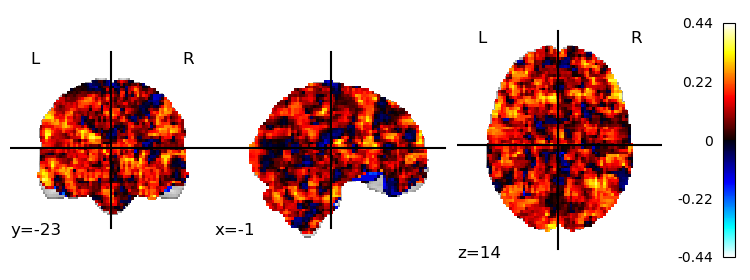

In [340]:
plotting.plot_stat_map(plot_img)

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_82076/3537548470.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


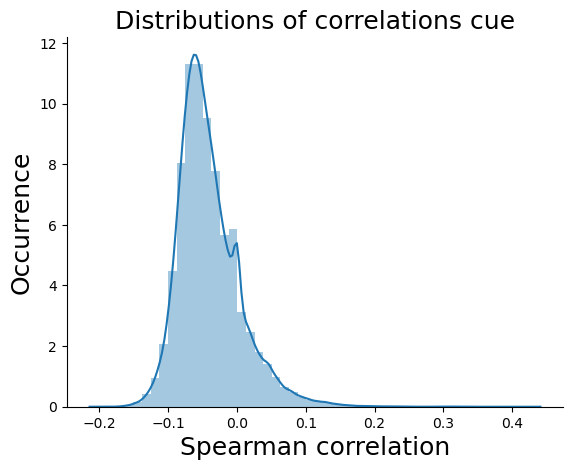

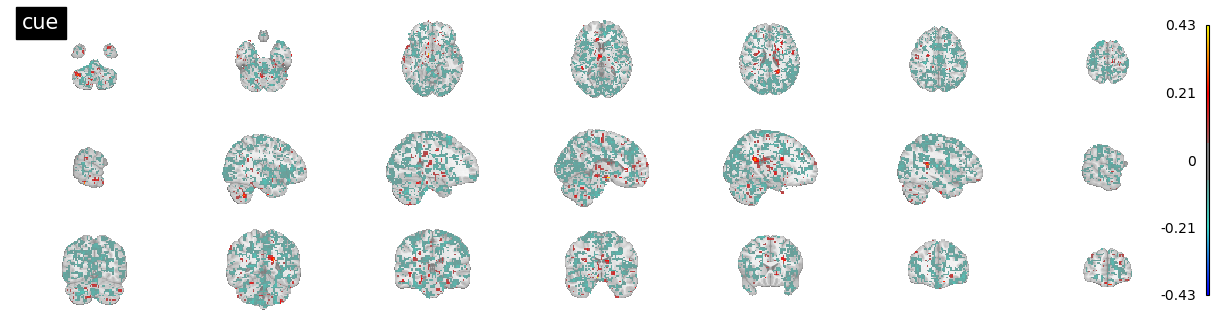

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_82076/3537548470.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


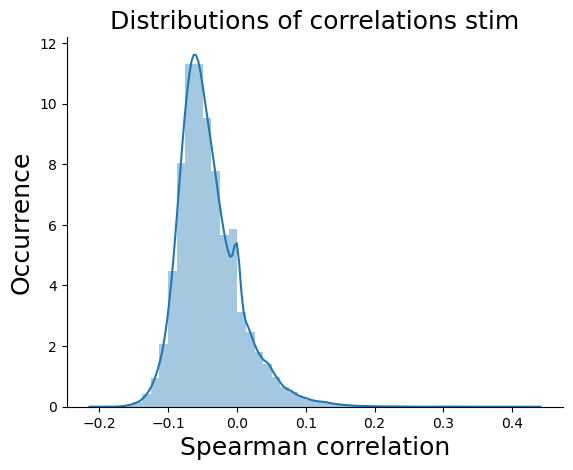

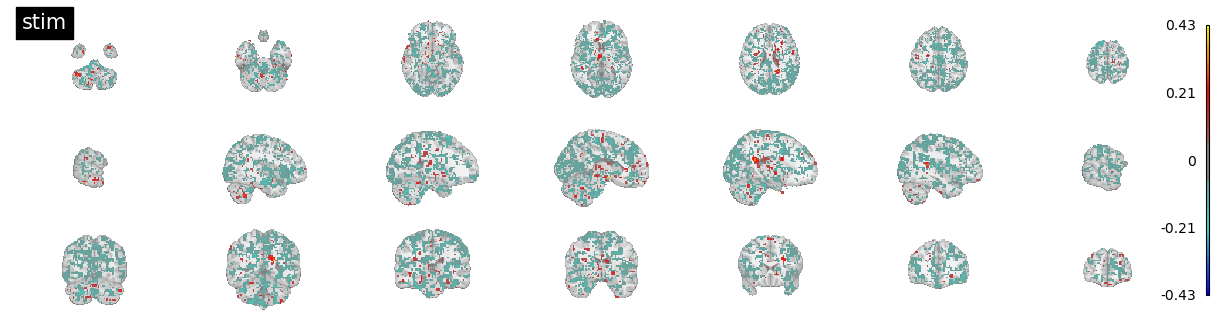

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_82076/3537548470.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


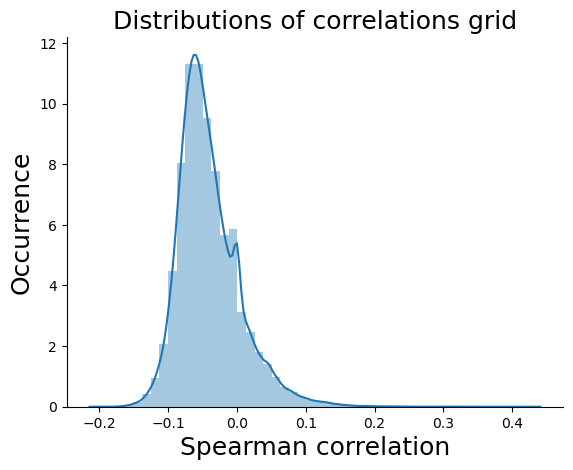

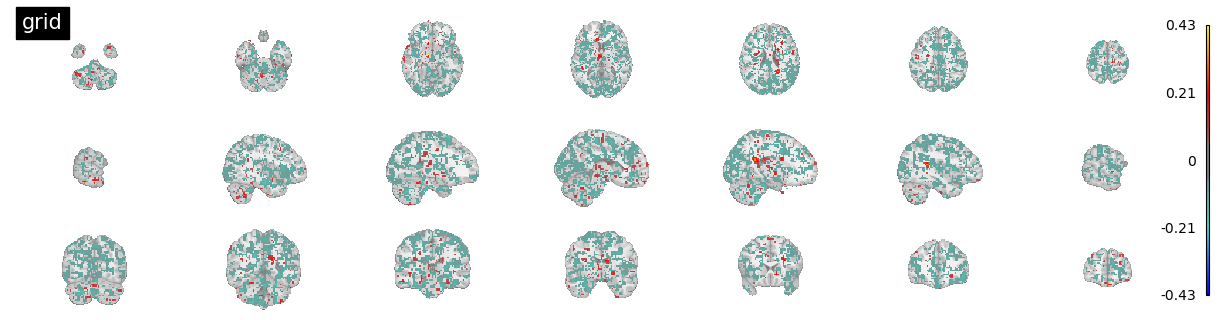

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_82076/3537548470.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


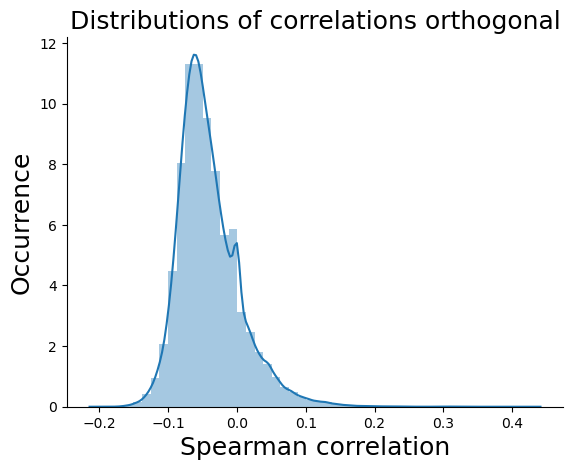

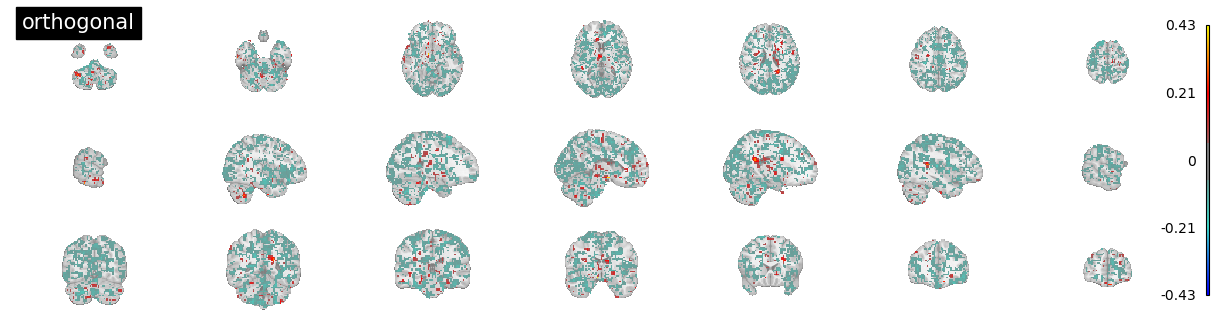

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_82076/3537548470.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


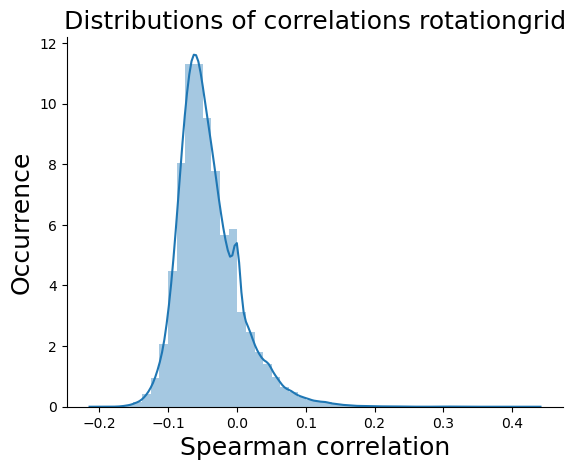

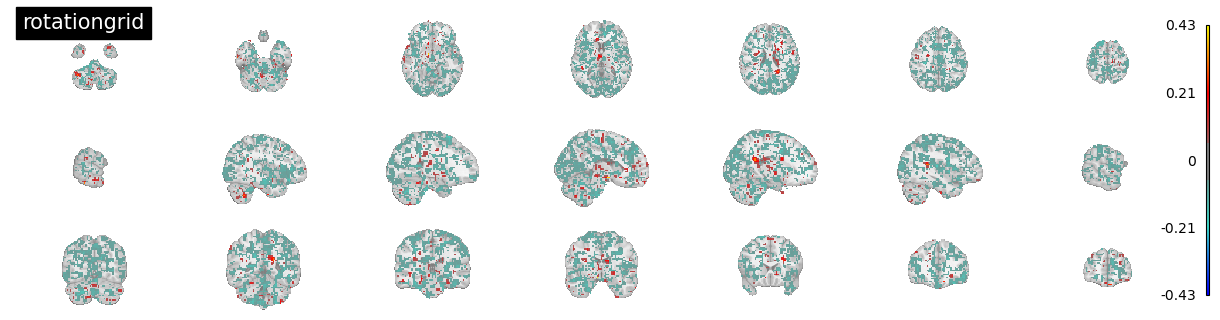

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_82076/3537548470.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


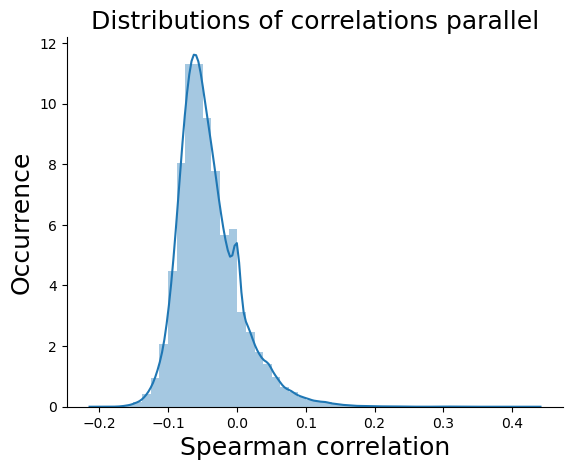

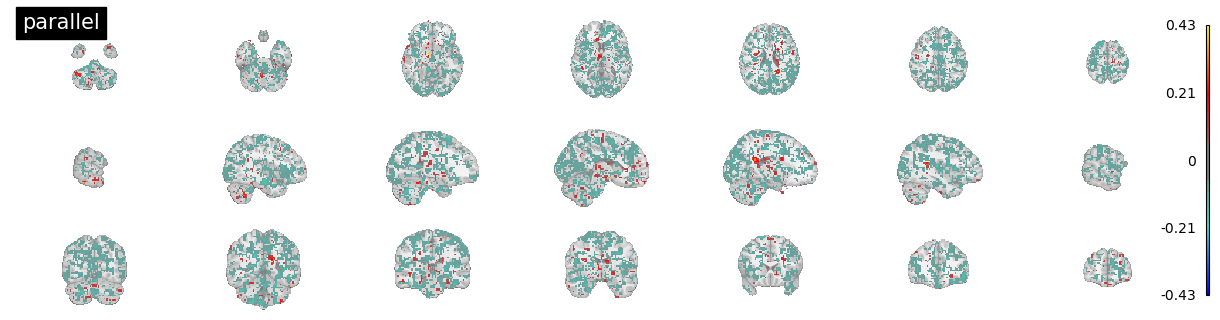

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_82076/3537548470.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


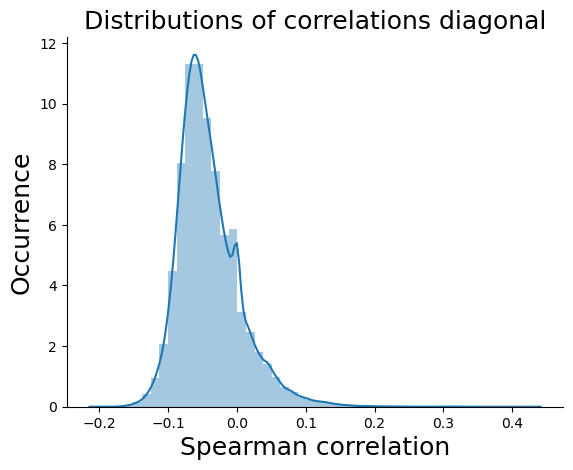

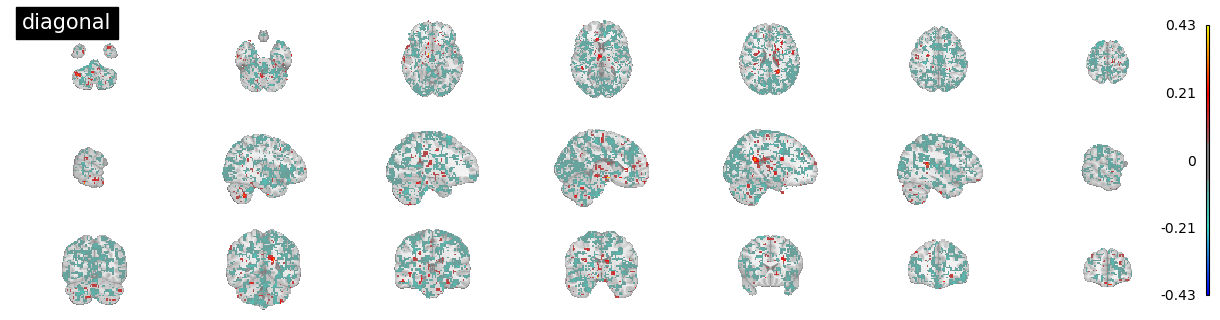

In [357]:
df = pd.DataFrame(index=range(len(X)), columns=range(len(eval_results)))
for i, e in enumerate(eval_results):
    df.iloc[:,i] = e.evaluations[0]

for model_i, model_name in enumerate(model_names):
    x, y, z = mask.shape
    RDM_brain = np.zeros([x*y*z])
    RDM_brain[list(SL_RDM.rdm_descriptors['voxel_index']), ] = df.T[model_i].tolist()
    RDM_brain_reshape = RDM_brain.reshape((x, y, z))

    sns.distplot(df.T[model_i].tolist())
    plt.title(f'Distributions of correlations {model_name}', size=18)
    plt.ylabel('Occurrence', size=18)
    plt.xlabel('Spearman correlation', size=18)
    sns.despine()
    
    # Save the distribution plot
    # plt.savefig(join(save_dir, f'searchlist-hist_{sub}_{ses}_model-{model_name}.png'))
    plt.show()
    # plt.close()
    
    threshold = np.percentile(df.T[model_i].tolist(), 97)
    plot_img = new_img_like(mask, RDM_brain_reshape)
    # masked_arr = nifti_masker.inverse_transform(fmri_masked_single)
    # plot_img.to_filename(join(save_dir, f"searchlight_{sub}_{ses}_model-{model_name}.nii.gz"))
    cmap = RDMcolormapObject()

    coords = range(-20, 40, 5)
    fig = plt.figure(figsize=(12, 3))

    display = plotting.plot_stat_map(
        plot_img, colorbar=True, threshold=threshold,
        display_mode='mosaic', draw_cross=False, figure=fig,
        title=f'{model_name}', cmap=cmap,
        black_bg=False, annotate=False)
    
    # Save the statistical map plot
    plt.show()
    # plt.savefig(join(save_dir, f'searchlight_thres-99_{sub}_{ses}_model-{model_name}.png'))
    # plt.close()

In [267]:
SL_RDM.dissimilarities.shape


(458294, 153)

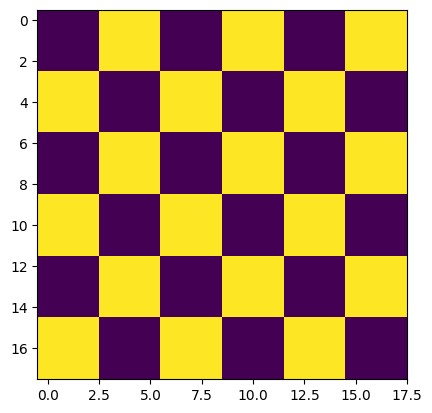

In [276]:
plt.imshow(squareform(pdist(cue_RDM)))

In [356]:
# eval_results = evaluate_models_searchlight(SL_RDM1, X, eval_fixed, method='spearman', n_jobs=3)
results_1 = rsatoolbox.inference.eval_fixed(X, SL_RDM, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1)

KeyboardInterrupt: 

In [72]:
theta1 = rsatoolbox.model.fitter.fit_optimize(X[0], SL_RDM, method='cosine', pattern_idx=None, pattern_descriptor=None, sigma_k=None, ridge_weight=0)

In [73]:
theta = rsatoolbox.model.fitter.fit_optimize(X[1], SL_RDM, method='cosine', pattern_idx=None, pattern_descriptor=None, sigma_k=None, ridge_weight=0)

# fixed

In [342]:
X = [rsatoolbox.model.ModelWeighted('cue', upper_tri(cue_RDM)),
     rsatoolbox.model.ModelWeighted('stim', upper_tri(stim_RDM)),
     rsatoolbox.model.ModelWeighted('grid', upper_tri(grid_RDM)),
     rsatoolbox.model.ModelWeighted('orthogonal', upper_tri(orthogonal_RDM)),
     rsatoolbox.model.ModelWeighted('rotationgrid', upper_tri(rotationgrid_RDM)),
     rsatoolbox.model.ModelWeighted('parallel', upper_tri(parallel_RDM)),
     rsatoolbox.model.ModelWeighted('diagonal', upper_tri(diagonal_RDM))]
cue_model = rsatoolbox.model.ModelFixed('cue RDM', upper_tri(cue_RDM))

In [343]:
model_names = ['cue', 'stim', 'grid', 'orthogonal', 'rotationgrid',  'parallel', 'diagonal']   
eval_results = evaluate_models_searchlight(SL_RDM, cue_model, eval_fixed, method='spearman', n_jobs=3)

Evaluating models for each searchlight: 100%|██████████| 97040/97040 [01:00<00:00, 1615.39it/s]


In [344]:
cue_eval_score

[-0.06789459363643001,
 -0.02431160121479153,
 -0.05603527597067804,
 -0.06018603715369123,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.061371968920266425,
 -0.08924136543478353,
 -0.05900010538711603,
 -0.05929658832875983,
 -0.15031685141340617,
 -0.09190971190957774,
 -0.07619611600245638,
 -0.08182929189368857,
 -0.10080420015889172,
 -0.08686950190163314,
 -0.09072378014300254,
 -0.09694992191752233,
 0.023718635331503934,
 -0.05959307127040363,
 -0.06018603715369123,
 -0.061075485978622626,
 -0.05573879302903424,
 -0.029944777106023713,
 -0.04714078772136407,
 -0.0681910765780738,
 -0.05129154890437725,
 0.029351811222736116,
 -0.06196493480355402,
 -0.07145238893615559,
 -0.08686950190163314,
 -0.05781417362054084,
 -0.06315086657012922,
 -0.031723674755886506,
 -0.04684430477972027,
 -0.08005039424382576,
 -0.04951265125451446,
 -0.09368860955944054,
 -0.08657301895998934,
 -0.03261312358081791,
 0.08598005307670174,
 -0.005633175891232183,
 -0.10050771721724791,
 -0.12689469902354603,
 -0.054

In [353]:
cue_eval_score = [e.evaluations[0][0][0] for e in eval_results]

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_82076/1786278233.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(cue_eval_score))


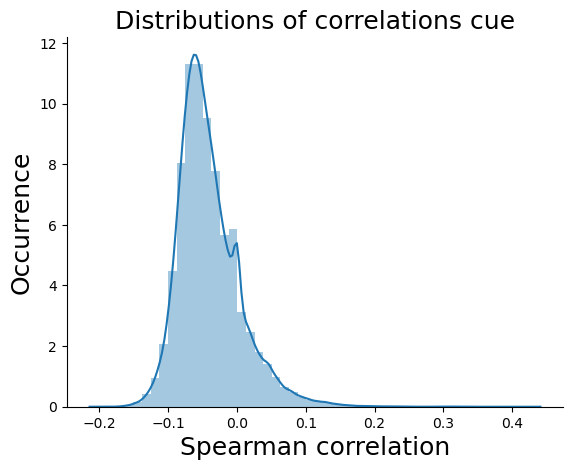

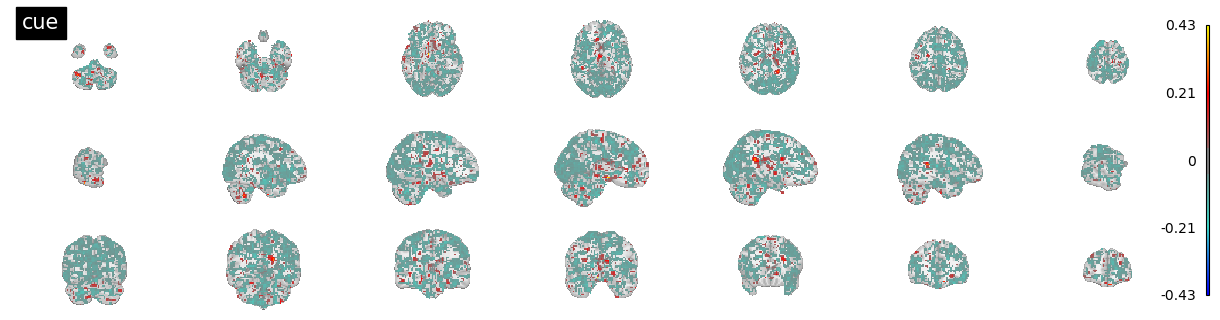

In [354]:
cue_eval_score = [e.evaluations[0][0][0] for e in eval_results]
model_name = 'cue'
x, y, z = mask.shape
RDM_brain = np.zeros([x*y*z])
RDM_brain[list(SL_RDM.rdm_descriptors['voxel_index'])] = list(cue_eval_score) #df.T[model_i].tolist()
RDM_brain_reshape = RDM_brain.reshape([x,y,z])

sns.distplot(list(cue_eval_score))
plt.title(f'Distributions of correlations {model_name}', size=18)
plt.ylabel('Occurrence', size=18)
plt.xlabel('Spearman correlation', size=18)
sns.despine()

# Save the distribution plot
# plt.savefig(join(save_dir, f'searchlist-hist_{sub}_{ses}_model-{model_name}.png'))
plt.show()
# plt.close()

threshold = np.percentile(list(cue_eval_score), 95)
plot_img = new_img_like(mask, RDM_brain_reshape)
# masked_arr = nifti_masker.inverse_transform(fmri_masked_single)
# plot_img.to_filename(join(save_dir, f"searchlight_{sub}_{ses}_model-{model_name}.nii.gz"))
cmap = RDMcolormapObject()

coords = range(-20, 40, 5)
fig = plt.figure(figsize=(12, 3))

display = plotting.plot_stat_map(
    plot_img, colorbar=True, threshold=threshold,
    display_mode='mosaic', draw_cross=False, figure=fig,
    title=f'{model_name}', cmap=cmap,
    black_bg=False, annotate=False)

# Save the statistical map plot
plt.show()